# Tensorflow Setup and Utility Functions

This notebook provides essential functions for setting up a Tensorflow Environment, loading and preprocessing image datasets, and visualizing the data. It's designed to be flexible and adaptable to various directory structures and image formats.

## Imports

- **tensorflow (tf)**: The main library for machine learning operations.
- **numpy (np)**: A library for numerical operations on large, multi-dimensional arrays and matrices.
- **matplotlib.pyplot (plt)**: A library for creating visualizations.
- **seaborn (sns)**: A library for creating more attractive visualizations.
- **pandas (pd)**: A library for data manipulation and analysis.
- **time**: A library for working with time and measuring performance.
- **pathlib.Path**: Provides an object-oriented interface for working with filesystem paths.
- **typing**: A library for type hints and annotations.
- **datetime**: A library for working with dates and times.
- **tqdm**: A library for creating interactive progress bars.
- **sklearn**: A library for machine learning operations.

## GPU Functions

The following functions are used to set up the Tensorflow environment and check for the presence of a GPU.


In [1]:
import warnings
import os
import logging

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.FATAL)
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

warnings.filterwarnings("ignore")

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from tqdm import tqdm
from pathlib import Path
from typing import Tuple, List, Dict, Optional
from datetime import datetime
from sklearn.manifold import TSNE

### Tensorflow Auxiliary Functinons and Configuration


In [4]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.17.0


### Setting Up GPU Configuration


In [5]:
import gc
import psutil
from dataclasses import dataclass, field

In [6]:
@dataclass
class MemoryConfig:
    max_memory_gb: float = 8.0
    batch_size: int = 32
    prefetch_buffer: int = 2
    cache_dataset: bool = True
    mixed_precision: bool = True
    memory_growth: bool = True

In [7]:
def setup_gpu() -> Tuple[tf.distribute.Strategy, int]:
    """
    Set up a GPU strategy for tensorflow.

    This function does the following
    1. Detects available GPUs.
    2. Sets up an appropriate strategy for the available GPUs.
    3. Returns the strategy and number of GPUs available.

    This function handles three cases:
    - No GPUs: returns a default strategy using CPU.
    - Single GPU: returns a MirroredStrategy with a single device.
    - Multiple GPUs: returns a MirroredStrategy with all available devices.

    Returns:
      tuple: (tf.distribute.Strategy, int) where the first element is the strategy and the second element is the number of GPUs available.
    """

    gpus = tf.config.list_physical_devices("GPU")
    num_gpus = len(gpus)

    if num_gpus == 0:
        print(f"No GPUs detected. Running on CPU.")
        return tf.distribute.get_strategy(), 0

    elif num_gpus == 1:
        print(f"1 GPU detected: {gpus[0].name}")
        return tf.distribute.MirroredStrategy(), 1

    else:
        print(f"{num_gpus} GPUs detected: {[gpu.name for gpu in gpus]}")
        return tf.distribute.MirroredStrategy(), num_gpus

In [8]:
strategy, num_gpus = setup_gpu()

1 GPU detected: /physical_device:GPU:0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


I0000 00:00:1730316600.641415  178946 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730316600.698577  178946 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730316600.700457  178946 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730316600.703788  178946 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [9]:
def setup_tensorboard():
    """
    Setup a TensorBoard for visualization. To view the TensorBoard, run the following command in the terminal:
    tensorboard --logdir logs/scalars
    """

    logdir = "logs/scalars" + datetime.now().strftime("%Y%m%d-%H%M%S")
    file_writer = tf.summary.create_file_writer(str(logdir + "/metrics"))
    file_writer.set_as_default()

    print(f"TensorBoard logs will be saved to: {logdir}")

In [10]:
def benchmark_data_pipeline(dataset: tf.data.Dataset):
    """
    Benchmark the data pipeline to ensure efficient data loading.

    Args:
      dataset (tf.data.Dataset): Dataset to benchmark.
    """

    start_time = time.time()
    for _ in tqdm(dataset, desc="Benchmarking data pipeline"):
        pass

    end_time = time.time()
    print(f"Data pipeline benchmark: {end_time - start_time:.2f} seconds")

### Auxiliary Functions


In [11]:
def load_dataset(
    train_data_path,
    val_data_path,
    img_size: Tuple[int, int] = (224, 224),
    batch_size: int = 32,
) -> Tuple[tf.data.Dataset, tf.data.Dataset, List[str]]:
    """
    Load and preprocess data using tf.data API.

    Args:
      data_path (str): Path to the data directory.
      img_size (tuple): Image size to resize to.
      batch_size (int): Batch size.
      validation_split (float): Fraction of data to use for validation.

    Returns:
      tuple: (tf.data.Dataset, tf.data.Dataset) where the first element is the training dataset and the second element is the validation dataset.

    """

    train_dir = Path(train_data_path)
    val_dir = Path(val_data_path)

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
    )

    train_class_names = train_ds.class_names
    val_class_names = val_ds.class_names
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, train_class_names, val_class_names

In [12]:
def load_best_model(model_path: str) -> tf.keras.Model:
    """
    Load the best model from a given path.

    Args:
      model_path (str): Path to the model directory.

    Returns:
      tf.keras.Model: Model loaded from the given path.
    """

    best_model_path = Path(model_path) / "best_model.keras"
    return tf.keras.models.load_model(str(best_model_path))

## Data Augmentation


In [13]:
import albumentations as A

In [14]:
import tensorflow as tf
import albumentations as A
from typing import Tuple, Optional
import numpy as np


class DataAugmentation(tf.keras.layers.Layer):
    def __init__(self, img_size: Tuple[int, int] = (224, 224), p: float = 0.8):
        """
        Focused data augmentation for nighttime cattle classification.

        Args:
            img_size: Target image size (height, width)
            p: Global probability of applying augmentations
        """
        super().__init__()
        self.img_size = img_size
        self.p = p

        # Compile simple, stable transformation pipeline
        self.transform = A.Compose(
            [
                # Essential brightness and contrast adjustments
                A.OneOf(
                    [
                        A.RandomBrightnessContrast(
                            brightness_limit=(0.2, 0.4),
                            contrast_limit=(0.1, 0.3),
                            p=0.8,
                        ),
                        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
                    ],
                    p=0.9,
                ),
                # Basic geometric transformations
                A.HorizontalFlip(p=0.5),
                # Simple noise reduction
                A.MedianBlur(blur_limit=3, p=0.2),
                # Ensure proper pixel value range
                A.ToFloat(max_value=255.0),
            ]
        )

    def augment(self, image):
        try:
            # Convert to numpy and ensure correct shape
            image_np = image.numpy()

            # Normalize if needed
            if image_np.max() > 1.0:
                image_np = image_np / 255.0

            # Apply augmentation
            augmented = self.transform(image=image_np)["image"]

            # Ensure output is float32 and in correct range
            augmented = np.clip(augmented, 0, 1).astype(np.float32)

            return augmented
        except Exception as e:
            print(f"Error in augment: {str(e)}")
            return image

    @tf.function
    def call(self, images, training=None):
        if not training:
            return images

        # Ensure input is float32
        images = tf.cast(images, tf.float32)
        if tf.reduce_max(images) > 1.0:
            images = images / 255.0

        # Apply augmentation
        augmented_images = tf.map_fn(
            lambda x: tf.py_function(self.augment, [x], Tout=tf.float32),
            images,
            dtype=tf.float32,
        )

        # Ensure output shape matches input
        augmented_images.set_shape(images.shape)
        return augmented_images

    def get_config(self):
        config = super().get_config()
        config.update({"img_size": self.img_size, "p": self.p})
        return config

### Visualization Functions


In [15]:
def visualize_data_augmentation(
    dataset, data_augmentation, num_images=3, num_augmentations=4, figsize=(15, 5)
):
    """
    Visualize the effects of data augmentation on images from the dataset.
    """
    # Get sample images

    sample_images = []
    for images, _ in dataset.take(1):
        for i in range(min(num_images, len(images))):
            sample_images.append(images[i])

    # Create figure
    plt.figure(figsize=figsize)

    for i, original_image in enumerate(sample_images):
        # Show original image
        plt.subplot(num_images, num_augmentations + 1, i * (num_augmentations + 1) + 1)

        # Convert to proper range for display
        display_image = tf.cast(original_image, tf.float32)
        if tf.reduce_max(display_image) > 1.0:
            display_image = display_image / 255.0

        plt.imshow(display_image)
        plt.axis("off")
        if i == 0:
            plt.title("Original")

        # Generate and show augmented versions
        for j in range(num_augmentations):
            plt.subplot(
                num_images, num_augmentations + 1, i * (num_augmentations + 1) + j + 2
            )

            # Apply augmentation
            augmented = data_augmentation(
                tf.expand_dims(original_image, 0), training=True
            )

            # Display augmented image
            plt.imshow(tf.squeeze(augmented))
            plt.axis("off")
            if i == 0:
                plt.title(f"Aug {j+1}")

    plt.tight_layout()
    plt.show()

In [16]:
def show_batch(dataset: tf.data.Dataset, class_names: List[str]):
    """
    Display a batch of images from the dataset.

    Args:
        dataset (tf.data.Dataset): Dataset to display.
        class_names (list): List of class names.
    """

    plt.figure(figsize=(10, 10))

    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)

            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

In [17]:
def analyze_class_distribution(dataset: tf.data.Dataset, class_names: List[str]):
    """
    Analyze and visualize the class distribution in the dataset.

    Args:

        dataset (tf.data.Dataset): Dataset to analyze.
        class_names (list): List of class names.
    """

    class_counts = {name: 0 for name in class_names}
    for _, labels in tqdm(dataset, desc="Analyzing class distribution"):
        for label in labels:
            class_counts[class_names[label]] += 1

    df = pd.DataFrame.from_dict(class_counts, orient="index", columns=["count"])
    df = df.sort_values("count", ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=df.index, y=df["count"], data=df)

    plt.title("Class distribution in the dataset")
    plt.xlabel("Class names")
    plt.ylabel("Count")

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [18]:
def visualize_features(
    dataset: tf.data.Dataset, class_names: List[str], num_samples: int = 1000
):
    """
    Visualize high-dimensional features using t-SNE.

    Args:
        dataset (tf.data.Dataset): Dataset to extract features from.
        class_names (list): List of class names.
        num_samples (int): Number of samples to visualize.
    """

    feature_model = tf.keras.applications.MobileNetV2(include_top=False, pooling="avg")
    features, labels = [], []

    for images, batch_labels in tqdm(
        dataset.take(num_samples // 32), desc="Extracting features"
    ):
        batch_features = feature_model(images)
        features.extend(batch_features.numpy())
        labels.extend(batch_labels.numpy())

    features = np.array(features)
    labels = np.array(labels)
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        x=features_2d[:, 0],
        y=features_2d[:, 1],
        hue=labels,
        palette="tab10",
        legend="full",
        alpha=0.8,
    )

    plt.title("t-SNE visualization of high-dimensional features")
    plt.tight_layout()
    plt.show()

In [19]:
def visualize_model_architecture(model: tf.keras.Model, name: str = "base_model"):
    """
    Visualize the architecture of the model

    Args:
      model: Model to visualize
      name: Name of the model
    """

    tf.keras.utils.plot_model(
        model,
        to_file=f"{name}.png",
        show_shapes=True,
        show_layer_names=False,
    )

    print("Model architecture visualization saved to base_model_architecture.png")

In [20]:
def visualize_training_history(
    history,
    figsize: Tuple[int, int] = (15, 5),
    save_path: str = None,
    include_lr: bool = True,
):
    """
    Visualizes the training history of a model.


    Args:

        history: History object returned by model.fit()
        figsize: Figure size for the plot
        save_path: If provided, saves the plot to this path
        include_lr: Whether to include learning rate plot
    """

    metrics = len(history.history.keys())

    if include_lr and "lr" in history.history:
        n_plots = 3

    else:
        n_plots = 2

    fig = plt.figure(figsize=figsize)

    # Plot accuracy
    plt.subplot(1, n_plots, 1)
    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    # Add horizontal grid lines
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot loss
    plt.subplot(1, n_plots, 2)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot learning rate if available
    if include_lr and "lr" in history.history:
        plt.subplot(1, n_plots, 3)
        plt.plot(history.history["lr"])
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.yscale("log")

    plt.tight_layout()

    # Add summary statistics
    best_epoch = np.argmin(history.history["val_loss"])
    best_val_loss = min(history.history["val_loss"])
    best_val_acc = max(history.history["val_accuracy"])

    print("\nTraining Summary:")
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch + 1})")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Total Epochs: {len(history.history['loss'])}")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        print(f"\nPlot saved to: {save_path}")

    plt.show()


def visualize_detailed_history(
    history, figsize: Tuple[int, int] = (15, 10), save_path: str = None
):
    """
    Creates a detailed visualization of the training history with additional metrics.

    Args:
        history: History object returned by model.fit()
        figsize: Figure size for the plot
        save_path: If provided, saves the plot to this path
    """

    fig = plt.figure(figsize=figsize)

    # Plot main metrics
    plt.subplot(2, 2, 1)
    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.subplot(2, 2, 2)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot accuracy and loss differences (training vs validation)
    plt.subplot(2, 2, 3)
    acc_diff = np.array(history.history["accuracy"]) - np.array(
        history.history["val_accuracy"]
    )

    plt.plot(acc_diff, label="Train-Val Difference")
    plt.title("Accuracy Difference (Training - Validation)")
    plt.xlabel("Epoch")
    plt.ylabel("Difference")
    plt.axhline(y=0, color="r", linestyle="--", alpha=0.3)
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot learning rate if available, otherwise plot loss difference
    plt.subplot(2, 2, 4)
    if "lr" in history.history:
        plt.plot(history.history["lr"])
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.yscale("log")

    else:
        loss_diff = np.array(history.history["loss"]) - np.array(
            history.history["val_loss"]
        )

        plt.plot(loss_diff, label="Train-Val Difference")
        plt.title("Loss Difference (Training - Validation)")
        plt.xlabel("Epoch")
        plt.ylabel("Difference")

    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()

    # Print summary statistics
    best_epoch = np.argmin(history.history["val_loss"])
    best_val_loss = min(history.history["val_loss"])
    best_val_acc = max(history.history["val_accuracy"])
    final_epoch = len(history.history["loss"])

    print("\nTraining Summary:")
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch + 1})")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Total Epochs: {final_epoch}")

    if "lr" in history.history:
        print(f"Final Learning Rate: {history.history['lr'][-1]:.2e}")

    # Calculate overfitting metrics
    final_acc_diff = acc_diff[-1]
    max_acc_diff = np.max(acc_diff)
    print(f"\nOverfitting Metrics:")
    print(f"Final Accuracy Difference: {final_acc_diff:.4f}")
    print(f"Max Accuracy Difference: {max_acc_diff:.4f}")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        print(f"\nPlot saved to: {save_path}")

    plt.show()

## Model Creation


### Transfer Learning


In [21]:
@dataclass(frozen=True)
class ModelConfig:
    backbone: str = "MobileNetV3Small"
    input_shape: Tuple[int, int, int] = (192, 192, 3)
    num_classes: int = 4
    head_units: int = 128
    batch_size: int = 16
    epochs: int = 50
    train_size: int = 2525
    learning_rate: float = 1e-4
    weight_decay: float = 0.03
    dropout_rate: float = 0.6

In [22]:
def create_cow_counting_model(config: ModelConfig, strategy) -> tf.keras.Model:
    with strategy.scope():
        base_model = tf.keras.applications.ResNet50V2(
            weights="imagenet", include_top=False, input_shape=config.input_shape
        )

        for layer in base_model.layers[-30:]:
            layer.trainable = True

        for layer in base_model.layers[:-30]:
            layer.trainable = False

        inputs = tf.keras.layers.Input(shape=config.input_shape)
        data_augmentation = DataAugmentation(config.input_shape[:2])

        x = data_augmentation(inputs)

        x = tf.keras.layers.GaussianNoise(0.15)(inputs)
        x = base_model(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)

        residual = x
        x = tf.keras.layers.Dense(2048, use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Dropout(0.5)(x)

        x = tf.keras.layers.Dense(2048, use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, residual])
        x = tf.keras.layers.Activation("relu")(x)

        x = tf.keras.layers.Dense(1024, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.Dense(config.head_units, activation="relu")(x)
        x = tf.keras.layers.Dropout(config.dropout_rate)(x)

        outputs = tf.keras.layers.Dense(config.num_classes, activation="softmax")(x)

        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        optimizer = tf.keras.optimizers.AdamW(
            learning_rate=config.learning_rate, weight_decay=config.weight_decay
        )

        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=["accuracy"],
        )

        return model

In [23]:
def create_callback(
    experiment_name: str = None, base_dir: str = "models", patience: int = 15
) -> List:
    """
    Creates model callbacks with organized directory structure and versioning.

    Args:
        experiment_name (str): Name of the experiment
        base_dir (str): Base directory to save the model.
        patience (int): Number of epochs to wait before early stopping.

    Returns:
        list: List of callbacks.
    """

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    if experiment_name is None:
        experiment_name = f"cattle_classification_{timestamp}"

    else:
        experiment_name = f"{experiment_name}_{timestamp}"

    model_dir = Path(base_dir) / experiment_name / "checkpoints"
    log_dir = Path(base_dir) / experiment_name / "logs"

    model_dir.mkdir(parents=True, exist_ok=True)
    log_dir.mkdir(parents=True, exist_ok=True)

    best_model_path = model_dir / "best_model.keras"
    latest_model_path = model_dir / "latest_model.keras"

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(best_model_path),
            save_best_only=True,
            monitor="val_accuracy",
            mode="max",
            verbose=1,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.2,
            patience=patience,
            min_lr=1e-7,
            mode="min",
            verbose=1,
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=str(log_dir),
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            update_freq="epoch",
            profile_batch=0,
        ),
        tf.keras.callbacks.CSVLogger(
            str(model_dir / "training.csv"),
            append=True,
        ),
    ]

    return callbacks, str(model_dir)

## Loading everything


### Hyperparameters


In [24]:
EPOCHS: int = 50
BATCH_SIZE: int = 32
IMG_SIZE: Tuple[int, int] = (224, 224)

### Loading the dataset


In [25]:
train_base_path = "../data/processed/split/train/night"
val_base_path = "../data/processed/split/val/night"

In [26]:
train_ds, val_ds, train_class_names, val_class_names = load_dataset(
    train_base_path, val_base_path, IMG_SIZE, BATCH_SIZE
)

Found 2525 files belonging to 11 classes.
Found 491 files belonging to 11 classes.


### Showing the data


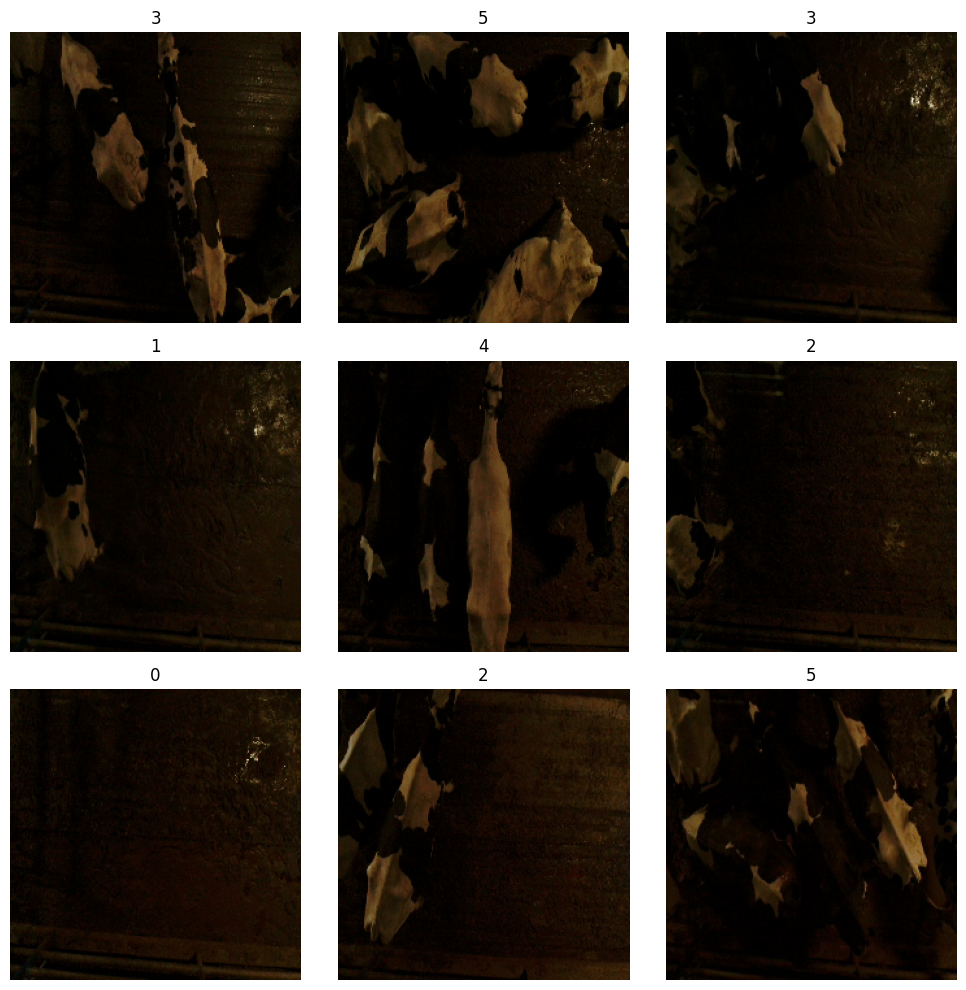

In [27]:
show_batch(train_ds, train_class_names)

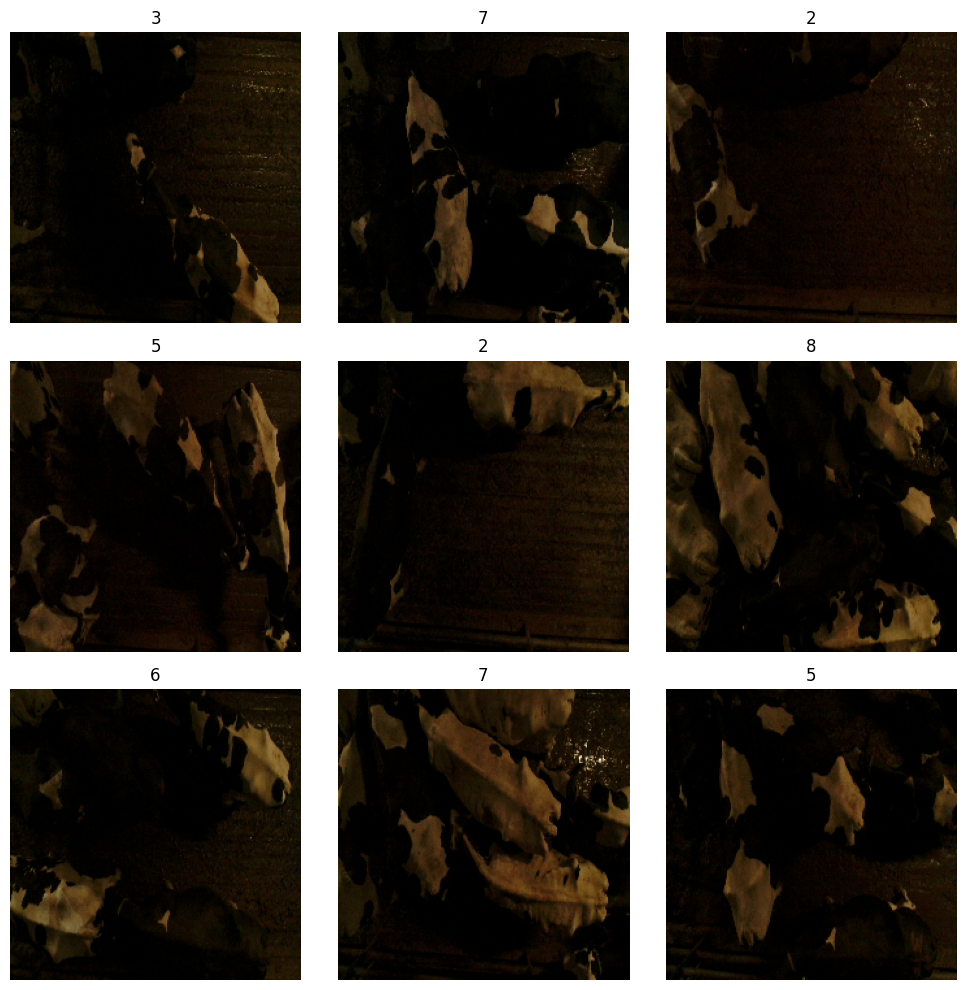

In [28]:
show_batch(val_ds, val_class_names)

Analyzing class distribution: 100%|██████████| 79/79 [00:00<00:00, 203.36it/s]


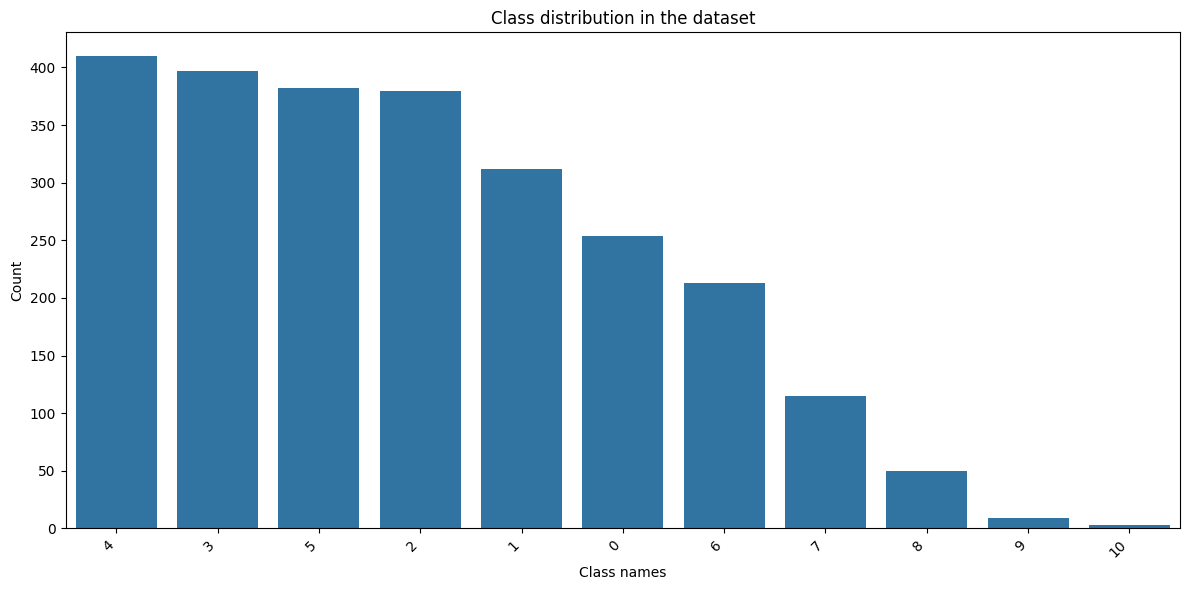

In [29]:
analyze_class_distribution(train_ds, train_class_names)

Analyzing class distribution: 100%|██████████| 16/16 [00:00<00:00, 37.27it/s]


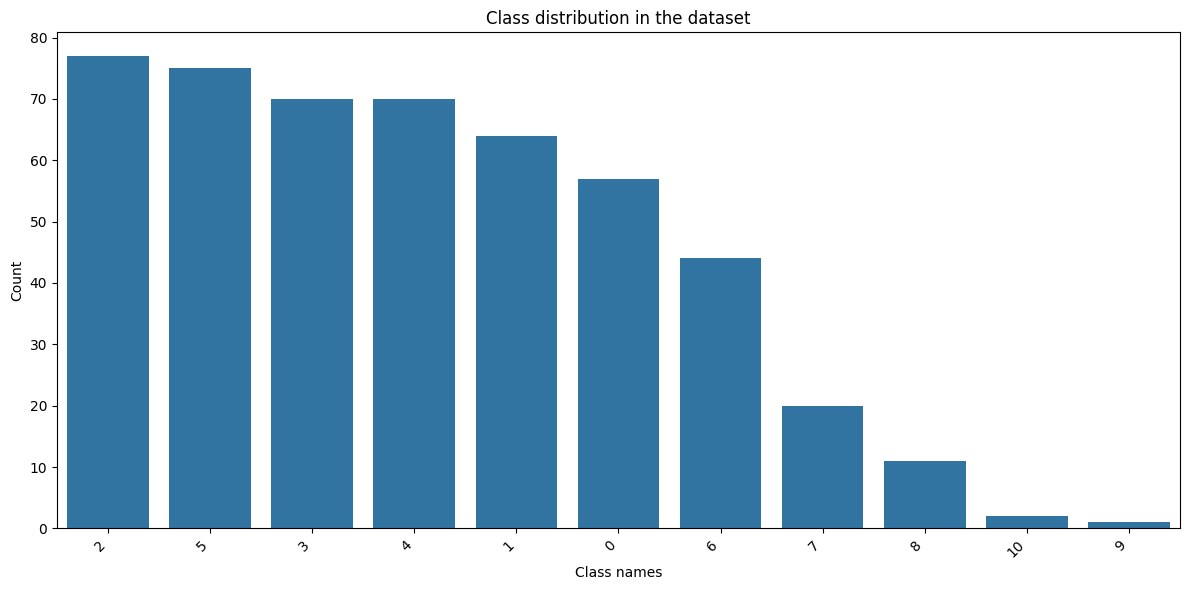

In [30]:
analyze_class_distribution(val_ds, val_class_names)

Instructions for updating:
Use fn_output_signature instead


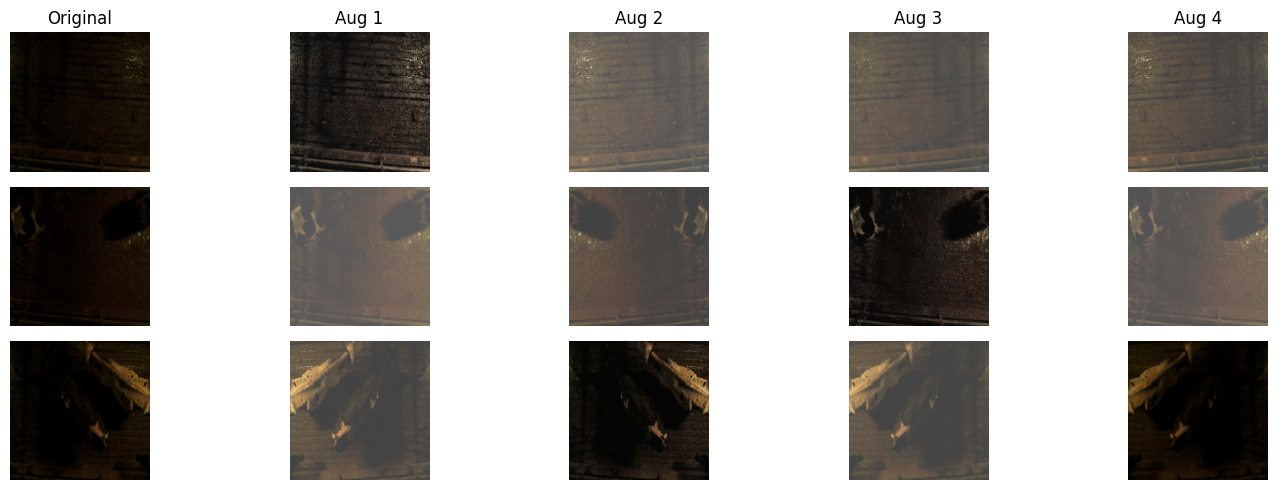

In [31]:
data_augmentation = DataAugmentation(IMG_SIZE)

visualize_data_augmentation(
    dataset=train_ds,
    data_augmentation=data_augmentation,
    num_images=3,
    num_augmentations=4,
)

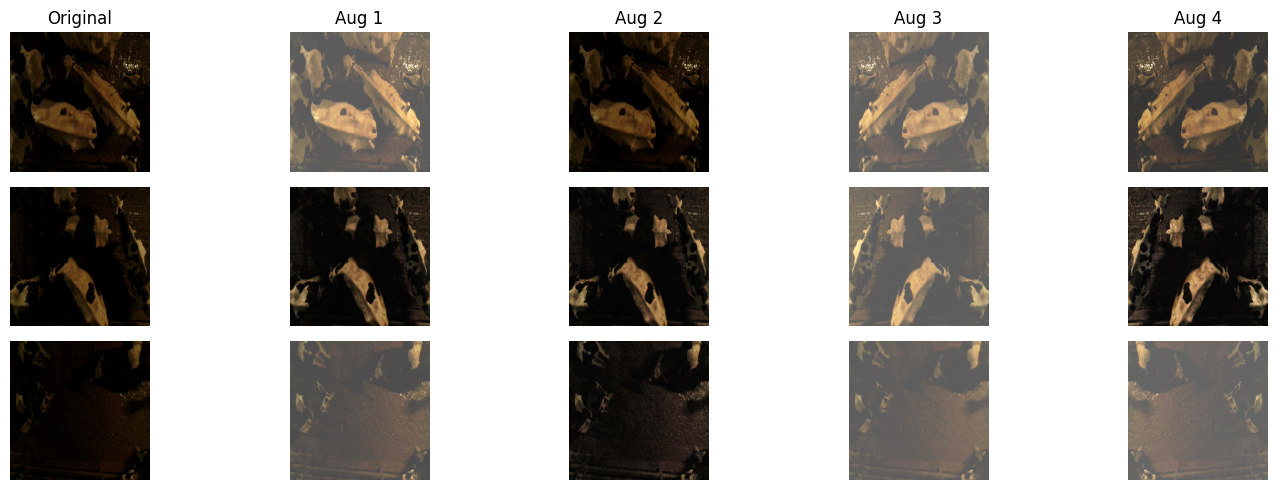

In [32]:
visualize_data_augmentation(
    dataset=val_ds,
    data_augmentation=data_augmentation,
    num_images=3,
    num_augmentations=4,
)

### Creating the base model


In [33]:
config = ModelConfig(
    num_classes=len(train_class_names),
    input_shape=(224, 224, 3),
    learning_rate=5e-4,
    weight_decay=0.01,
    dropout_rate=0.3,
    train_size=len(train_ds),
)

In [34]:
model = create_cow_counting_model(config, strategy)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (GaussianNoise)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 7, 7,      │ 23,564,800 │ gaussian_noise[0… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  4,194,304 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2048)      │      8,192 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 2048)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2048)      │  4,194,304 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2048)      │          0 │ batch_normalizat… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 2048)      │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │  2,098,176 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1024)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    524,800 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 11)        │      1,419 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,659,851 (132.22 MB)

 Trainable params: 25,530,379 (97.39 MB)

 Non-trainable params: 9,129,472 (34.83 MB)

In [35]:
callbacks, model_dir = create_callback(
    experiment_name="night_cattle_classification", patience=10
)

In [36]:
with strategy.scope():
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
    )

Epoch 1/50


W0000 00:00:1730316616.715480  179056 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316616.748314  179056 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316616.750556  179056 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316616.752789  179056 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316616.755007  179056 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316616.761251  179056 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316616.768820  179056 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316616.771942  179056 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316616.775840  179056 gp

56/79 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.2155 - loss: 2.2866

W0000 00:00:1730316628.122685  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316628.124642  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316628.126552  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316628.128350  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316628.130212  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316628.132508  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316628.135114  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316628.137754  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316628.140196  179053 gp

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2241 - loss: 2.2147

W0000 00:00:1730316634.084046  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316634.086183  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316634.088080  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316634.090342  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316634.092592  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316634.100942  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316634.104637  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316634.138473  179053 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316634.142462  179053 gp


Epoch 1: val_accuracy improved from -inf to 0.29939, saving model to models/night_cattle_classification_20241030-133011/checkpoints/best_model.keras


W0000 00:00:1730316635.974470  179055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316635.975472  179055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316635.976717  179055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316635.978004  179055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316635.979407  179055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316635.980710  179055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316635.982172  179055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316635.983554  179055 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1730316635.985387  179055 gp

79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 248ms/step - accuracy: 0.2246 - loss: 2.2120 - val_accuracy: 0.2994 - val_loss: 1.9158 - learning_rate: 5.0000e-04
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3258 - loss: 1.6287
Epoch 2: val_accuracy improved from 0.29939 to 0.38086, saving model to models/night_cattle_classification_20241030-133011/checkpoints/best_model.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.3261 - loss: 1.6280 - val_accuracy: 0.3809 - val_loss: 1.5201 - learning_rate: 5.0000e-04
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4093 - loss: 1.4387
Epoch 3: val_accuracy did not improve from 0.38086
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.4093 - loss: 1.4386 - val_accuracy: 0.3544 - val_loss: 1.6320 - learning_rate: 5.0000e-04
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.4463 - loss: 1.3517
Epoch 4: val_accuracy did not improve from 0.38086
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accura


Training Summary:
Best Validation Loss: 1.2177 (Epoch 13)
Best Validation Accuracy: 0.6191
Final Training Accuracy: 0.9362
Final Validation Accuracy: 0.6090
Total Epochs: 50

Overfitting Metrics:
Final Accuracy Difference: 0.3273
Max Accuracy Difference: 0.3361

Plot saved to: models/night_cattle_classification_20241030-133011/checkpoints/training_plot.png


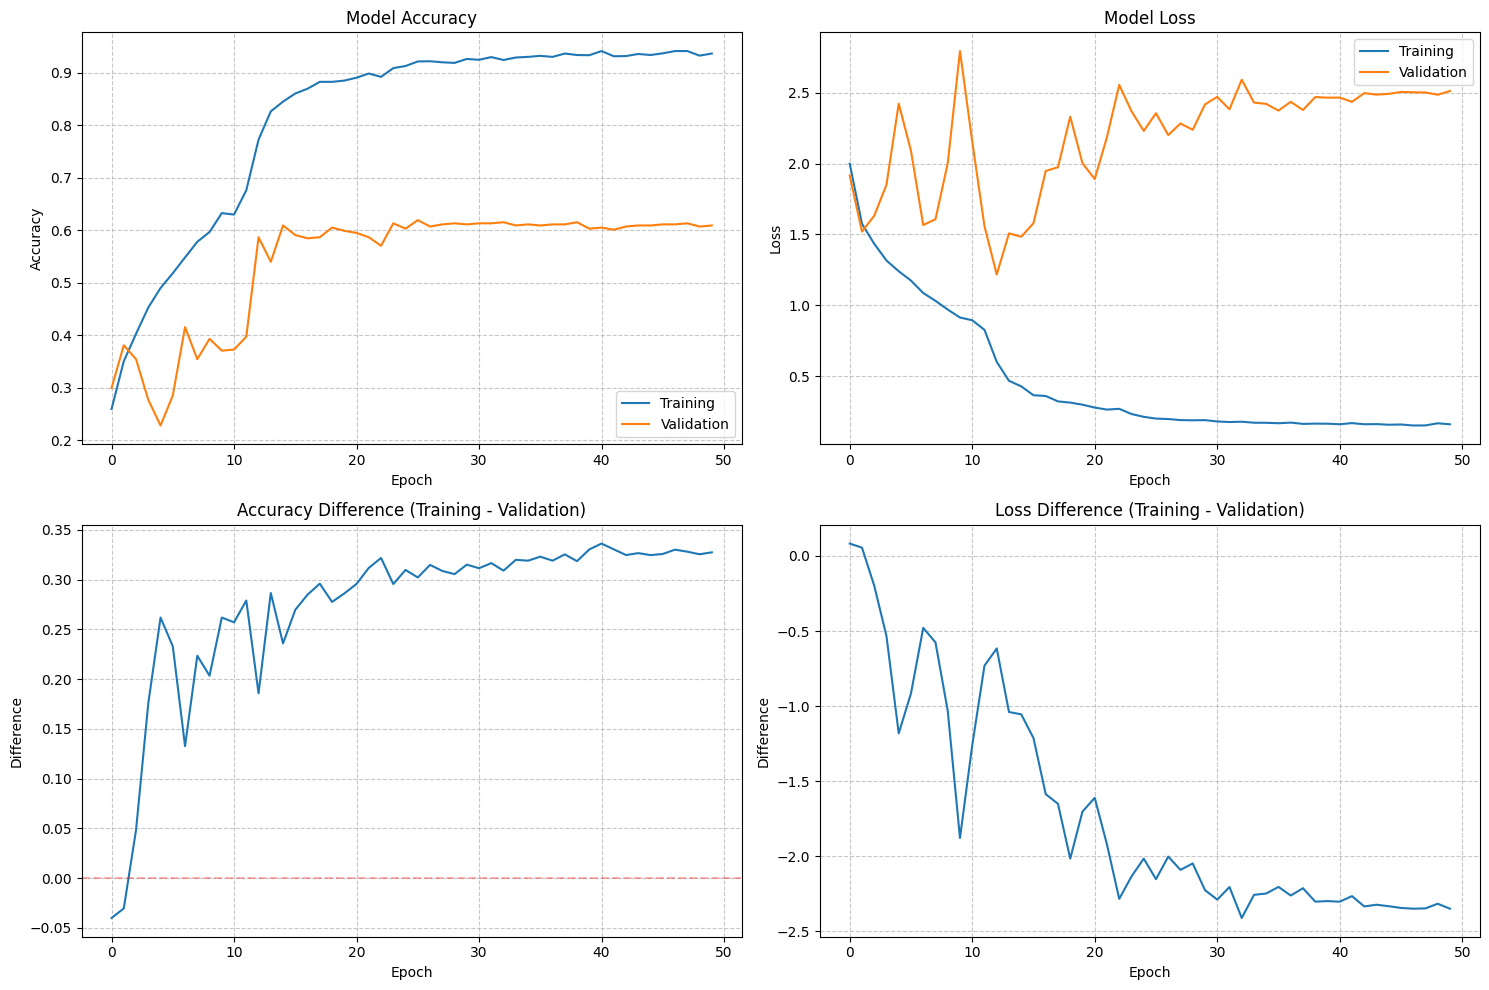

In [37]:
visualize_detailed_history(history, save_path=f"{model_dir}/training_plot.png")

## Prediction


In [38]:
test_base_path = "../data/processed/split/test/night"

In [39]:
test_ds, _, test_class_names, _ = load_dataset(
    test_base_path, val_base_path, IMG_SIZE, BATCH_SIZE
)

Found 331 files belonging to 10 classes.
Found 491 files belonging to 11 classes.


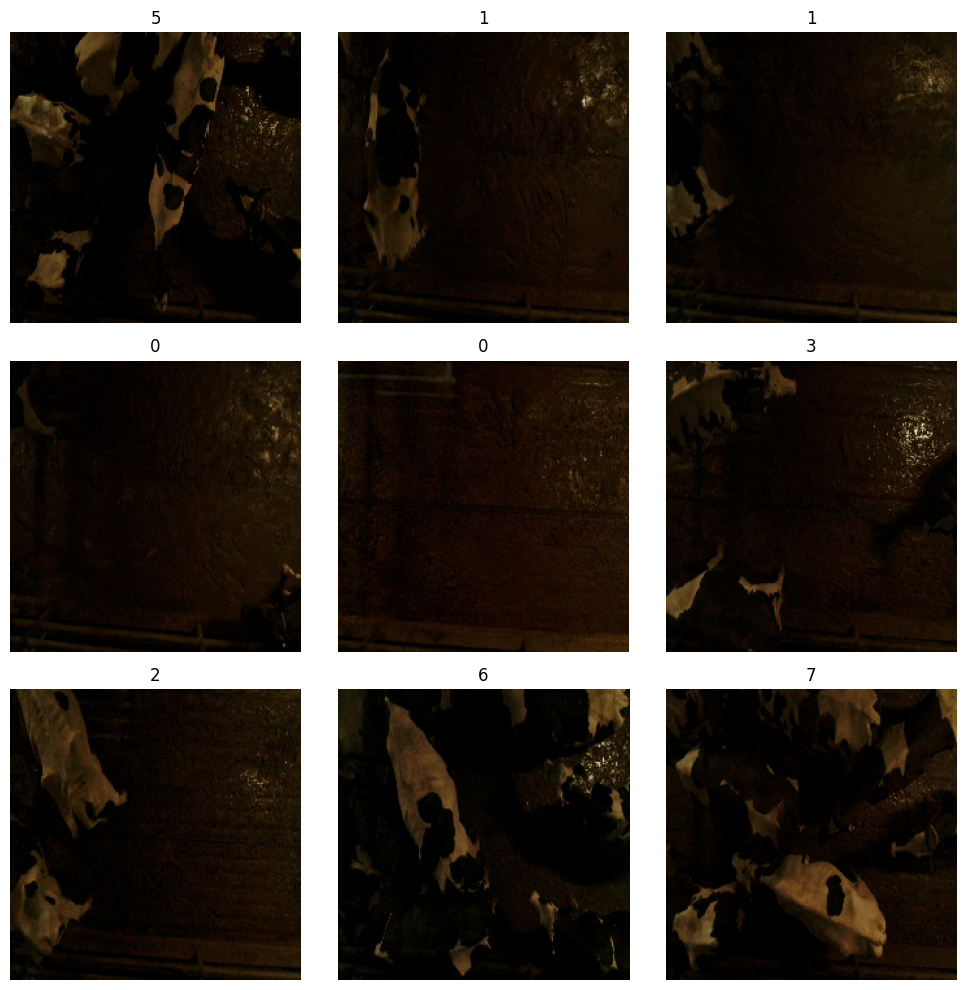

In [40]:
show_batch(test_ds, test_class_names)

In [42]:
best_model = load_best_model(model_dir)
test_loss, test_accuracy = best_model.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.3736 - loss: 8.7809
